In [1]:
import numpy as np
import keras
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

Using Theano backend.


In [2]:
#data = pd.read_csv("data/samples/113_t_air.csv")
data = np.load('data/113_28_all.npy')

In [3]:
X = data[:,:13, 0]

y = data[:, 18:, 0]

# dates = data["time_now"]

In [4]:
print (X.shape)
print (y.shape)

(6040, 13)
(6040, 4)


In [5]:
class My3DScaler:
    def __init__(self, feature_range):
        self.feature_range = feature_range
    def fit(self, X):
        self.shape = X.shape
        assert len(self.shape) == 3
        self.n_scalers = self.shape[2]
        self.scalers=[]
        for i in range(self.n_scalers):
            scaler = MinMaxScaler(feature_range=self.feature_range)
            scaler.fit(X[:,:,i])
            self.scalers.append(scaler)
    def transform(self, X):
        assert self.shape == X.shape
        X_ = np.zeros_like(X)
        for i in range(self.n_scalers):
            print '---'
            print X[:,:,i]
            print '---'
            X_[:,:,i] = self.scalers[i].transform(X[:,:,i])
        return X_

    def fit_transform(self, X):
        self.shape = X.shape
        self.scalers = []
        X_ = np.zeros_like(X)
        for i in range(self.shape[2]):
#             print '---'
#             print X[:,:,i]
#             print '---'
            scaler = MinMaxScaler(feature_range=self.feature_range)
            X_[:,:,i] = scaler.fit_transform(X[:,:,i])
            self.scalers.append(scaler)
        return X_
    def inverse_transform(self, X):
        #assert self.shape == X.shape
        X_ = np.zeros_like(X)
        for i in range(self.shape[2]):
            X_[:,:,i] = self.scalers[i].inverse_transform(X[:,:,i])
        return X_
        

In [6]:
scaller_t = MinMaxScaler(feature_range=(0, 1))
scaller_yt = MinMaxScaler(feature_range=(0, 1))
# scaller_hour = MinMaxScaler(feature_range=(0, 1))
# scaller_day_from = MinMaxScaler(feature_range=(0, 1))

X_scaled = scaller_t.fit_transform(X)
y_scaled = scaller_yt.fit_transform(y)
#scaller_hour.fit(X[:, 14])
#scaller_day_from.fit(X[:, 13])

In [7]:
X_scaled.shape

(6040, 13)

In [8]:
train_size = 4800
X_train, y_train = np.array(X_scaled)[:train_size], np.array(y_scaled)[:train_size]
X_test, y_test   = np.array(X_scaled)[train_size:], np.array(y_scaled)[train_size:]
#test_dates = np.array(dates)[train_size:]

In [9]:
X.shape

(6040, 13)

In [10]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(4800, 13)
(4800, 4)
(1240, 13)
(1240, 4)


In [11]:
from keras.models import Sequential
from keras import optimizers
#from keras.layers.core import Dropout, Dense
from keras.layers.core import Dense, Dropout, Activation, Reshape, Flatten
from keras.layers import BatchNormalization, Conv1D, MaxPooling1D
from keras.layers import LSTM

In [68]:
def corrupt(X, p):
    p = 0.1
    mask = np.random.choice([0, 1], size=X.shape, p=[p, 1-p])
    X_corrupted = (X + np.random.normal(size=X.shape, scale=0.01))*mask
    return X_corrupted

In [80]:
from keras import backend as K
from IPython.display import clear_output

def get_output(X, model):
    inp = model.input                                           # input placeholder
    outputs = [layer.output for layer in model.layers]          # all layer outputs
    functor = K.function([inp], outputs ) # evaluation function

    layer_outs = functor([X])
    return layer_outs

In [111]:
def train_ae(X, units, batches, epochs):
    p = 0.1
    X_corrupted = corrupt(X, p)
    AE = Sequential()
    l = Dense(units, input_shape=(X.shape[1],), name='ae', activation='tanh')
    AE.add(l)
    AE.add(Dense(X.shape[1], activation='tanh'))
    AE.compile(loss='mean_squared_error', optimizer='adam')
    for batch_size in tqdm(batches):
        AE.fit(X_corrupted, X, epochs=epochs, batch_size=batch_size, verbose=0)

    #print(AE.evaluate(X_corrupted, X, batch_size=100, verbose=2))

    return l.get_weights(), get_output(X, AE)[0]

In [147]:
def train_net(X, units_array, batches, epochs):
    weights_array = []
    inputs = [X]
    n = len(units_array)
    for i in tqdm(range(n)):
        weights, new_X = train_ae(inputs[i], units_array[i], batches, epochs)
        weights_array.append(weights)
        inputs.append(new_X)
    
    AE = Sequential()
    l = Dense(units_array[0], input_shape=(X.shape[1],), activation='tanh')
    AE.add(l)
    
    assert len(l.get_weights()) == len(weights_array[0])
    assert l.get_weights()[0].shape == weights_array[0][0].shape
    
    l.set_weights(weights_array[0])
    
    for i in range(1, n):
        l = Dense(units_array[i], activation='tanh')
        AE.add(l)
        
        assert l.get_weights()[0].shape == weights_array[i][0].shape
        l.set_weights(weights_array[i])
        
    
    AE.add(Dense(4))
    #AE.add(Activation("linear"))
    AE.compile(loss='mean_absolute_error', optimizer='adam')        
        
    return AE

In [163]:
def create_MLP(units_array):

    model = Sequential()
    model.add(Dense(units_array[0], input_shape=(X.shape[1],), activation='tanh'))
    for units in units_array[1:]:
        model.add(Dense(units, activation='tanh'))
    model.add(Dense(4))
    #model.add(Activation('linear'))
    model.compile(loss='mean_absolute_error', optimizer='adam')        
    
    return model

In [168]:
def evaluate_model(model):
    
    y_pred = scaller_yt.inverse_transform(model.predict(X_train))

    print 'Train'
    print('MSE=', mse(scaller_yt.inverse_transform(y_train), y_pred))
    print('MAE=', mae(scaller_yt.inverse_transform(y_train), y_pred))

    print '============================================'
    print 'Test'
    y_pred = scaller_yt.inverse_transform(model.predict(X_test))
    print('MSE=', mse(scaller_yt.inverse_transform(y_test), y_pred))
    print('MAE=', mae(scaller_yt.inverse_transform(y_test), y_pred))


In [167]:
def compare_models(X, y, batches, units_array, epochs):
    print("Pre-training AE...")
    AE = train_net(X, units_array, batches, epochs)
    MLP = create_MLP(units_array)
    print("Training NNs...")
    for batch_size in tqdm(batches):
        AE.fit(X, y, epochs=epochs, batch_size=batch_size, verbose=0)
        MLP.fit(X, y, epochs=epochs, batch_size=batch_size, verbose=0)
    
    print("Evaluating...")
    print "AE loss:", AE.evaluate(X, y, batch_size=1000, verbose=0)
    print "MLP loss:", MLP.evaluate(X, y, batch_size=1000, verbose=0)
    

    print("AE")
    evaluate_model(AE)
    print ''
    print("MLP")
    evaluate_model(MLP)
    
    return AE, MLP
    #print(AE.evaluate(X_train, y_train, batch_size=100))

In [169]:
from tqdm import tqdm_notebook as tqdm

batches = [10, 50, 100, 500, 1000]
units_array = [60, 500, 200, 300]
epochs = 10

AE, MLP = compare_models(X_train, y_train, batches, units_array, epochs)
#AE = train_net(X_train, units_array, batches, epochs)

Pre-training AE...

Training NNs...

Evaluating...
('AE loss:', 0.024932782670172553)
('MLP loss:', 0.025164049933664501)
AE
Train
('MSE=', 496.55072134094235)
('MAE=', 14.465926021523369)
Test
('MSE=', 895.72746142742994)
('MAE=', 22.205583204455397)

MLP
Train
('MSE=', 502.14400020433038)
('MAE=', 14.600107651865486)
Test
('MSE=', 947.57036558097639)
('MAE=', 23.067536251920327)


In [170]:
import time
import datetime

dates = data["time_now"]
s = "2013-03-04 08:30:00"
converted = []
for date in dates:
    converted.append(time.mktime(datetime.datetime.strptime(s, "%Y-%m-%d %H:%M:%S").timetuple()))

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [282]:
origin = datetime.datetime.fromtimestamp(60*30*24)
half_an_hour = datetime.timedelta(0, 30)
list_of_datetimes = [origin]
for _ in y_test[:999]:
    list_of_datetimes.append(list_of_datetimes[-1] + half_an_hour)
#datetime.datetime.fromtimestamp(60*60*24*365)

def beautify(t_air_test, t_air_pred, list_of_datetimes):
    plt.figure(figsize=(10, 10))
    dates = matplotlib.dates.date2num(list_of_datetimes)
    #plt.plot_date(dates, t_air_test, c="b")
    plt.plot_date(dates, t_air_pred, c="r")
    
    beautify(t_air_test, t_air_pred, list_of_datetimes)

In [3]:
y_pred = y_pred_test
y_train_pred = y_pred_train

t_air_test = scaller_yt.inverse_transform(y_test)[:1000]
t_air_train = scaller_yt.inverse_transform(y_train)[:1000]
t_air_train_pred = y_train_pred[:1000]
t_air_pred = y_pred[:1000]
#plot_dates = test_dates[:1000]

NameError: name 'y_pred_test' is not defined

In [298]:
def beautify(t_air_test, t_air_pred, list_of_datetimes):
    plt.figure(figsize=(10, 10))
    dates = matplotlib.dates.date2num(list_of_datetimes)
    #plt.plot_date(dates, t_air_test, c="b")
    plt.plot_date(dates, t_air_pred, c="r")

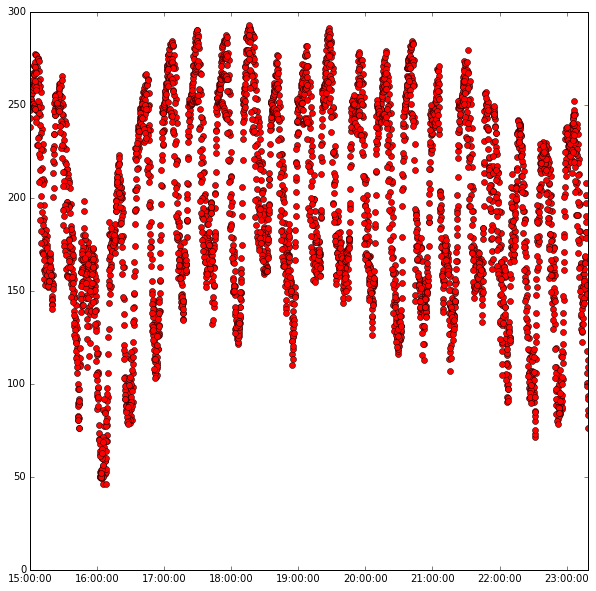

In [299]:
beautify(t_air_test, t_air_pred, list_of_datetimes)

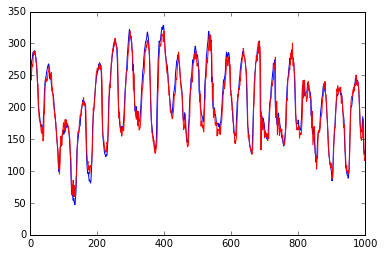

In [46]:
#plt.plot(scaler.inverse_transform(dataset))
#plt.plot_date(plot_dates, t_air_test[:, 0])
plt.plot(t_air_test[:, 0, 0], c="b")
plt.plot(t_air_pred[:, 0, 0], c="r")
plt.show()

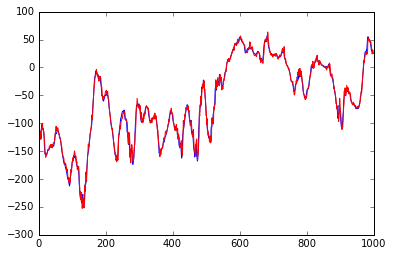

In [47]:
#plt.plot(scaler.inverse_transform(dataset))
#plt.plot_date(plot_dates, t_air_test[:, 0])
plt.plot(t_air_train[:, 0, 0], c="b")
plt.plot(t_air_train_pred[:, 0, 0], c="r")
plt.show()

In [150]:

model = Sequential()

model.add(Dense(60, input_shape=(X_train.shape[1],), activation='tanh'))
model.add(Dense(500, activation='tanh'))
#model.add(Dense(200, activation='tanh'))
#model.add(Dense(300, activation='tanh'))
model.add(Dense(4))
#model.add(Activation('linear'))
model.compile(loss='mean_absolute_error', optimizer='adam')        
        

In [151]:
batches = [10, 50, 100, 500, 1000]
for batch_size in tqdm(batches):
    model.fit(X_train, y_train, epochs=30, batch_size=batch_size, verbose=1)
    #print(AE.evaluate(X_train, y_train, batch_size=100))

Epoch 1/30
4800/4800 [==============================] - 0s - loss: 0.0458     
Epoch 2/30
4800/4800 [==============================] - 0s - loss: 0.0346     
Epoch 3/30
4800/4800 [==============================] - 0s - loss: 0.0312     
Epoch 4/30
4800/4800 [==============================] - 0s - loss: 0.0330     
Epoch 5/30
4800/4800 [==============================] - 0s - loss: 0.0308     
Epoch 6/30
4800/4800 [==============================] - 0s - loss: 0.0302     
Epoch 7/30
4800/4800 [==============================] - 0s - loss: 0.0306     
Epoch 8/30
4800/4800 [==============================] - 0s - loss: 0.0301     
Epoch 9/30
4800/4800 [==============================] - 0s - loss: 0.0306     
Epoch 10/30
4800/4800 [==============================] - 0s - loss: 0.0310     
Epoch 11/30
4800/4800 [==============================] - 0s - loss: 0.0313     
Epoch 12/30
4800/4800 [==============================] - 0s - loss: 0.0298     
Epoch 13/30
4800/4800 [==========================

In [152]:

y_pred = scaller_yt.inverse_transform(AE.predict(X_train))

print 'Train'
print('MSE=', mse(scaller_yt.inverse_transform(y_train), y_pred))
print('MAE=', mae(scaller_yt.inverse_transform(y_train), y_pred))

print '============================================'
print 'Test'
y_pred = scaller_yt.inverse_transform(AE.predict(X_test))
print('MSE=', mse(scaller_yt.inverse_transform(y_test), y_pred))
print('MAE=', mae(scaller_yt.inverse_transform(y_test), y_pred))


y_pred = scaller_yt.inverse_transform(model.predict(X_train))
print
print
print 'Train'
print('MSE=', mse(scaller_yt.inverse_transform(y_train), y_pred))
print('MAE=', mae(scaller_yt.inverse_transform(y_train), y_pred))

print '============================================'
print 'Test'
y_pred = scaller_yt.inverse_transform(model.predict(X_test))
print('MSE=', mse(scaller_yt.inverse_transform(y_test), y_pred))
print('MAE=', mae(scaller_yt.inverse_transform(y_test), y_pred))

Train
('MSE=', 514.87002251149227)
('MAE=', 15.188061430746004)
Test
('MSE=', 802.63799373657957)
('MAE=', 19.517940253680923)


Train
('MSE=', 500.21992458894692)
('MAE=', 14.514344692968258)
Test
('MSE=', 863.58157875457664)
('MAE=', 20.737263425334959)


In [141]:

y_pred = scaller_yt.inverse_transform(AE.predict(X_train))

print 'Train'
print('MSE=', mse(scaller_yt.inverse_transform(y_train), y_pred))
print('MAE=', mae(scaller_yt.inverse_transform(y_train), y_pred))

print '============================================'
print 'Test'
y_pred = scaller_yt.inverse_transform(AE.predict(X_test))
print('MSE=', mse(scaller_yt.inverse_transform(y_test), y_pred))
print('MAE=', mae(scaller_yt.inverse_transform(y_test), y_pred))


y_pred = scaller_yt.inverse_transform(model.predict(X_train))
print
print
print 'Train'
print('MSE=', mse(scaller_yt.inverse_transform(y_train), y_pred))
print('MAE=', mae(scaller_yt.inverse_transform(y_train), y_pred))

print '============================================'
print 'Test'
y_pred = scaller_yt.inverse_transform(model.predict(X_test))
print('MSE=', mse(scaller_yt.inverse_transform(y_test), y_pred))
print('MAE=', mae(scaller_yt.inverse_transform(y_test), y_pred))

Train
('MSE=', 521.56428467629166)
('MAE=', 14.83046661865151)
Test
('MSE=', 910.33216107757994)
('MAE=', 21.479762978222887)


Train
('MSE=', 531.67187991165156)
('MAE=', 15.014543323496856)
Test
('MSE=', 931.89408321801977)
('MAE=', 21.80101885272974)
